# 10. Attention Mechanisms

In [11]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [10]:
!pip install -U d2l

     |████████████████████████████████| 77 kB 3.5 MB/s eta 0:00:011
     |████████████████████████████████| 10.5 MB 10.6 MB/s eta 0:00:01


## 10.3 Attention Scoring Function

### 10.3.1 Masked Softmax 

In [15]:
def masked_softmax(X, valid_lens=None):
    """Perform softmax peration by masking elements on the last axis
    
    X: 3D tensor
    valid_lens: 1D or 2D tensor
    """
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    shape = X.shape
    if valid_lens.dim() == 1:
        valid_lens = torch.repeat_interleave(valid_lens, shape[1])
    else:
        valid_lens = valid_lens.reshape(-1)
    # On the last axis, replace masked elements with a very large negative
    # value, whose exponentiation outputs 0
    X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
    return nn.functional.softmax(X.reshape(shape), dim=-1)

In [17]:
masked_softmax(torch.rand(2, 2, 4))

tensor([[[0.1534, 0.2406, 0.3441, 0.2618],
         [0.2921, 0.2637, 0.1544, 0.2897]],

        [[0.2618, 0.1751, 0.3150, 0.2481],
         [0.1602, 0.3341, 0.2994, 0.2063]]])

To demonstrate how this function works, consider a minibatch of two  2×4  matrix examples, where the valid lengths for these two examples are two and three, respectively. As a result of the masked softmax operation, values beyond the valid lengths are all masked as zero.

In [13]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.3207, 0.6793, 0.0000, 0.0000],
         [0.6675, 0.3325, 0.0000, 0.0000]],

        [[0.3004, 0.2494, 0.4502, 0.0000],
         [0.1990, 0.3546, 0.4465, 0.0000]]])

Similarly, we can also use a two-dimensional tensor to specify valid lengths for every row in each matrix example.

In [14]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3385, 0.3167, 0.3448, 0.0000]],

        [[0.4109, 0.5891, 0.0000, 0.0000],
         [0.2427, 0.2453, 0.2751, 0.2369]]])

### 10.3.2 Additive attention

In general, when queries and keys are vectors of different lengths, we can use additive attention as the scoring function. Given a query  𝐪∈ℝ𝑞  and a key  𝐤∈ℝ𝑘 , the additive attention scoring function

(10.3.3)
𝑎(𝐪,𝐤)=𝐰⊤𝑣tanh(𝐖𝑞𝐪+𝐖𝑘𝐤)∈ℝ,
 
where learnable parameters  𝐖𝑞∈ℝℎ×𝑞 ,  𝐖𝑘∈ℝℎ×𝑘 , and  𝐰𝑣∈ℝℎ . Equivalent to (10.3.3), the query and the key are concatenated and fed into an MLP with a single hidden layer whose number of hidden units is  ℎ , a hyperparameter. By using  tanh  as the activation function and disabling bias terms, we implement additive attention in the following.

In [31]:
class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of `queries`: (`batch_size`, no. of
        # queries, 1, `num_hiddens`) and shape of `keys`: (`batch_size`, 1,
        # no. of key-value pairs, `num_hiddens`). Sum them up with
        # broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of `self.w_v`, so we remove the last
        # one-dimensional entry from the shape. Shape of `scores`:
        # (`batch_size`, no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of `values`: (`batch_size`, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

Let us demonstrate the above AdditiveAttention class with a toy example, where shapes (batch size, number of steps or sequence length in tokens, feature size) of queries, keys, and values are ( 2 ,  1 ,  20 ), ( 2 ,  10 ,  2 ), and ( 2 ,  10 ,  4 ), respectively. The attention pooling output has a shape of (batch size, number of steps for queries, feature size for values).

In [32]:
torch.normal(0, 1, (2, 1, 20))

tensor([[[-1.1710, -0.6664, -1.2517,  0.0241, -1.2035,  2.2504, -0.2603,
           0.7094, -0.3480, -0.0023,  0.8318, -1.0320,  0.5323,  1.4914,
          -0.2178,  0.0061,  0.7774,  0.6629,  1.4254, -1.0451]],

        [[-0.4456,  0.8572,  0.6440, -1.2186,  0.6644, -1.5970,  0.3152,
          -0.9658, -0.7422,  0.9225, -1.4014,  0.1003, -1.2713, -1.3655,
           2.2517,  0.3255,  0.9071,  1.6437, -1.1923,  0.8463]]])

In [33]:
torch.ones(2, 10, 2)

tensor([[[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]]])

In [34]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# The two value matrices in the `values` minibatch are identical
values = torch.arange(40, dtype=torch.float32).reshape(1, 10,
                                                       4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

Although additive attention contains learnable parameters, since every key is the same in this example, the attention weights are uniform, determined by the specified valid lengths.

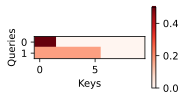

In [35]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

### 10.3.3 Scaled Dot-Product Attention

In [36]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens=None):
        """
        # Shape of `queries`: (`batch_size`, no. of queries, `d`)
        # Shape of `keys`: (`batch_size`, no. of key-value pairs, `d`)
        # Shape of `values`: (`batch_size`, no. of key-value pairs, value
        # dimension)
        # Shape of `valid_lens`: (`batch_size`,) or (`batch_size`, no. of queries)
        """
        d = queries.shape[-1]
        # Set `transpose_b=True` to swap the last two dimensions of `keys`
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

To demonstrate the above DotProductAttention class, we use the same keys, values, and valid lengths from the earlier toy example for additive attention. For the dot product operation, we make the feature size of queries the same as that of keys.


In [37]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

Same as in the additive attention demonstration, since keys contains the same element that cannot be differentiated by any query, uniform attention weights are obtained.

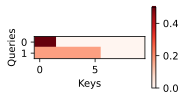

In [38]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')